In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make the notebook executable on google colab
if 'google.colab' in str(get_ipython()):
    # install package
    try:
      import gsemantique
    except ImportError:
      !git clone https://github.com/fkroeber/gsemantique.git
      !cd gsemantique && pip install .
    # change working directory
    demo_dir = "gsemantique/demo"
    import os
    if not os.getcwd().endswith(demo_dir):
      os.chdir(demo_dir)

## Intro

The scaled processing is mainly realised via a class called `TileHandler`. This class is designed to be initialised with arguments that are very similar to those usually provided to semantique's `QueryRecipe.execute()`, i.e. taking as input a <i>repice</i>, <i>datacube</i>, <i>mapping</i>, <i>space</i> and <i>time</i>. Additionally, some scaling-specific arguments can be specified, such as <i>chuncksize</i>, <i>tiling dimension</i>, <i>merge mode</i>, <i>output directory</i> and <i>reauthentication</i>. Note that for all of these scaling-specific attributes reasonable defaults are is place, such that you as a user don't need to worry too much about their configuration.

In [3]:
from gsemantique.process.scaling import TileHandler
?TileHandler

Init signature:
TileHandler(
    recipe,
    datacube,
    mapping,
    space,
    time,
    spatial_resolution,
    crs=None,
    chunksize_t='1W',
    chunksize_s=1024,
    tile_dim=None,
    merge_mode='merged',
    out_dir=None,
    caching=True,
    reauth=True,
    verbose=True,
    **config,
)
Docstring:     
Handler for executing a query in a (spatially or temporally) tiled manner.
Note that it currently only supports non-grouped outputs, i.e. results that are
concatenated after a groupby operation was called.

Parameters
----------
  recipe : QueryRecipe
    The query recipe to be processed.
  datacube : Datacube
    The datacube instance to process the query against.
  mapping : Mapping
    The mapping instance to process the query against.
  space : SpatialExtent
    The spatial extent in which the query should be processed.
  time : TemporalExtent
    The temporal extent in which the query should be processed.
  spatial_resolution : :obj:`list`
    Spatial resolution of the

If you want to run your analyses in a scaled manner, you simply need to call `.execute()` on your created `TileHandler` instance. The example below demonstrates this using a basic setup with a spatio-temporal extent of interest, a corresponding datacube and a suitable mapping.

In [4]:
import geopandas as gpd
import json
import pandas as pd
import semantique as sq
from gsemantique.data.datasets import *
from gsemantique.data.search import Finder
from gsemantique.process.scaling import TileHandler

# define spatio-temporal extent
res = 20
epsg = 32634
t_start, t_end = '2020-06-01', '2020-06-15'
time = sq.TemporalExtent(pd.Timestamp(t_start), pd.Timestamp(t_end))
aoi = gpd.GeoDataFrame.from_file("files/polygon.geojson").to_crs(4326)
space = sq.SpatialExtent(aoi)

# search for data & construct datacube
ds_catalog = DatasetCatalog()
ds_catalog.load()

fdr = Finder(ds_catalog, t_start, t_end, aoi.dissolve().geometry[0])
fdr.search_man(("Planet", "classification", "scl"))

with open("../gsemantique/data/layout.json", "r") as file:
    dc = sq.datacube.STACCube(
        json.load(file), 
        src = fdr.item_coll,
        group_by_solar_day=True,
        dask_params=None,
    )

# define exemplary mapping
mapping = sq.mapping.Semantique()
mapping["entity"] = {}
mapping["entity"]["vegetation"] = {
    "color": sq.layer("Planet", "classification", "scl").evaluate("equal", 4)
}

# define recipe
recipe = sq.QueryRecipe()
recipe["green_map"] = (
    sq.entity("vegetation")
    .reduce("percentage", "time")
)

# create TileHandler & execute recipe
th = TileHandler(recipe, dc, mapping, space, time, [-res, res], epsg)
th.execute()

creating spatial grid: 100%|██████████| 4/4 [00:00<00:00, 47.18it/s]


The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

-------------------------------------
General layer info
-------------------------------------
layer     : dtype     crs   res      
-------------------------------------
green_map : float64   32634 [-20, 20]
-------------------------------------

--------------------------------------------
Scenario: 'merge' = None
--------------------------------------------
layer     :  size     tile n     tile shape 
--------------------------------------------
green_map : 0.03 Gb  4 tile(s)  (1024, 1024)
--------------------------------------------
Total       0.03 Gb  4 tile(s)
--------------------------------------------

--------------------------------------------
Scenario: 'merge' = vrt_*
---------------------

executing recipe in tiled manner: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Given the default merge mode, the final results are accessible via the .tile_results attribute.

As can be observed from the demonstration above, the complexity of scaling when calling .execute() is abstracted from the user. Scaling operations are set up and carried out internally. Among these internally handled operations are the following:
* decision on how to tile the given spatio-temporal extent of interest into smaller chuncks based on an analyses of the recipe
* estimation of the expected output (in terms of size, shape, dtype) and anticipated processing time       
* execution of the recipe evaluation in a tiled manner relying on performance optimisations realised by caching redundant data layer I/O operations
* merging the tiled results depending on the choosen merging mode

This current notebook aims to explain these steps and other processing-relevant considerations in more detail, such that you understand the working mechanism of the internal processing pipeline and are make an informed decision when modifying the corresponding default values.

## Basics of tiled processing for upscaling

One fundamental limitation when scaling analysis across large spatio-temporal extents, is imposed by the available RAM space. For example, calculating the NDVI timeseries for a given year using all Sentinel-2 for a 100km x 100km large area may require more than 50GB RAM space if the whole data is read into memory to construct the data cube. Given a limited, fixed amount of RAM resources there are different ways how to proceed with such as situation, most of which rely on some division of data reading & processing into smaller chunks. Within gsemantique this chuking is realised on a per-recipe level. A given recipe is analysed for its operations and whether they require all observations for a given dimension (spatial or temporal one) to be coherent. The different possible situations are illustrated below. A recipe can either...
* operate on the temporal dimension, leaving the spatial one for chuncking  
* operate on the spatial dimension, leaving the temporal one for chuncking  
* operate on both dimensions, making chuncking on a recipe level infeasible

In [5]:
from gsemantique.process.scaling import TileHandler

# scenario I - temporal operations 
recipe_I = sq.QueryRecipe()
recipe_I["green_map"] = (
    sq.entity("vegetation")
    .reduce("percentage", "time")
)

# get the dimensions of the operation
print(f"Operations across: {TileHandler._get_op_dims(recipe_I)}")

# get the dimension for tiling
th = TileHandler(recipe_I, dc, mapping, space, time, [-res, res], epsg)
th._get_tile_dim()
print(f"Tiling along: {th.tile_dim}")

Operations across: ['time']
Tiling along: space


In [6]:
# scenario II - spatial operations 
recipe_II = sq.QueryRecipe()
recipe_II["vegetation_share"] = (
    sq.entity("vegetation")
    .groupby_space("feature")
    .reduce("percentage", "space")
)

# get the dimensions of the operation
print(f"Operations across: {TileHandler._get_op_dims(recipe_II)}")

# get the dimension for tiling
th = TileHandler(recipe_II, dc, mapping, space, time, [-res, res], epsg)
th._get_tile_dim()
print(f"Tiling along: {th.tile_dim}")

Operations across: ['space']
Tiling along: time


In [7]:
# scenario III - operations on both dimensions 
recipe_III = sq.QueryRecipe()
recipe_III["green_map"] = sq.entity("vegetation").reduce("percentage", "time")
recipe_III["cloud_stats"] = sq.entity("cloud").reduce("percentage", "space")

# get the dimensions of the operation
print(f"Operations across: {TileHandler._get_op_dims(recipe_III)}")

# get the dimension for tiling
th = TileHandler(recipe_III, dc, mapping, space, time, [-res, res], epsg)
th._get_tile_dim()
print(f"Tiling along: {th.tile_dim}")

Operations across: ['space', 'time']
Tiling along: None


c:\users\felix\repositories\gsemantique\gsemantique\process\scaling.py:216: UserWarning: Tiling not feasible. Tiling dimension is set to 'None'.
  warnings.warn("Tiling not feasible. Tiling dimension is set to 'None'.")


While the last scenario (operations on both dimensions) may occur, it is not further tackled by gsemantique. Instead it is assumed that most of these cases can be resolved by re-writing and splitting the recipe into smaller pieces operating on a single dimension enabling them to be evaluated independently or subsequently.

Given the derived tiling dimension, the .get_tile_grid() method is called to set up the tiling grid. Here, the arguments chunksize_s and chuncksize_t can be adjusted to modify the size of the tiles. The values should be set to the RAM-dependent maximum of what can be processed in single pass.

In [8]:
# get tiling grid
th = TileHandler(recipe, dc, mapping, space, time, [-res, res], epsg)
th._get_tile_grid()
print(f"number of tiles: {len(th.grid)}")

# same for smaller chunksize
th = TileHandler(recipe, dc, mapping, space, time, [-res, res], epsg, chunksize_s=256)
th._get_tile_grid()
print(f"number of tiles: {len(th.grid)}")

creating spatial grid: 100%|██████████| 4/4 [00:00<00:00, 41.05it/s]


number of tiles: 4


creating spatial grid: 100%|██████████| 42/42 [00:00<00:00, 53.14it/s]

number of tiles: 24


Since for the current example, the tiling is carried out in the spatial dimension, it is straightforward to visualise it with a map representation. The full spatial extent to be processed (here: an Norwegian island) is divided into 24 smaller tiles to be processed individually.

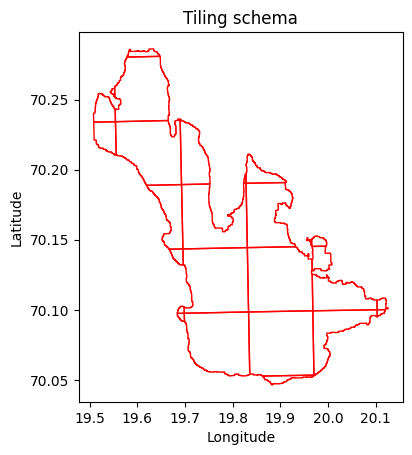

In [9]:
# visualise tiles
import matplotlib.pyplot as plt

gdfs = [gpd.GeoDataFrame.from_features(fc, crs=fc["crs"]) for fc in th.grid]
gdfs = [gdf.to_crs(epsg=4326) for gdf in gdfs]

fig, ax = plt.subplots()
for gdf in gdfs:
    gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

ax.set_title("Tiling schema")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## Results preview & output options

Depending on the choosen spatio-temporal extent, the final results may take a while to be calculated and they may consume a significant part of the available disk space to be saved locally. To reduce such uncertainties and avoid lengthly computations that do not meet the expected result, there is a .preview() function that is called routinely before computing the results for all tiles. The .preview() function evaluates the recipe for a single tile and extrapolates the results from this run to estimate the parameters of the final result. For every layer in the final response object, the preview function outputs two pieces of information:
1) general information: dtype, crs, resolution
2) merge mode dependent characteristics: size on disk, number & shapes of individual tiles 

Note that calling the .preview() function also controls the creation of a cache for the data layers to be called up repeatedly.

In [10]:
th.preview()

The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

-------------------------------------
General layer info
-------------------------------------
layer     : dtype     crs   res      
-------------------------------------
green_map : float64   32634 [-20, 20]
-------------------------------------

-------------------------------------------
Scenario: 'merge' = None
-------------------------------------------
layer     :  size      tile n    tile shape
-------------------------------------------
green_map : 0.01 Gb  24 tile(s)  (256, 256)
-------------------------------------------
Total       0.01 Gb  24 tile(s)
-------------------------------------------

-------------------------------------------
Scenario: 'merge' = vrt_*
----------------------------

The merge mode guides how tiled results shall be merged. For details see the docstring of `TileHandler` above. The basic choice is if you want the outputs to be merged into a single output again (merge_mode = "merged") or if you want to keep the results as tiles (merge_mode = None), possibly integrating them into a virtual raster (merge_mode = "vrt_shapes" | "vrt_tiles"). The later may be important in cases when you are processing large spatio-temporal extents, where the creation of a single merged output would exceed the available RAM space. Another use case for vrt outputs are input geometries that are spatially scattered or irregularly shaped, where a lot of NA values consuming a significant part of disk space would need to be written to create a single, rectangular output. When vrt outputs are choosen, pyramid overviews (.ovw) will be build along with the .vrt files such that the rendering of these files is speed-up. 

Note that in any case (even with the default merge_mode = "merged"), results will likely not be 100% congruent to the results obtained from a non-tiled run (i.e. simply using QueryRecipe.execute()). This is mainly due to 2 reasons: 
1. The individual tile outputs will be postprocessed to ensure that they are array-like outputs with at most 3 dimensions. For higher-diemensional outputs, the remaining non-spatial dimensions will be stacked into a single dimension. This is enables writing them to disk in common formats such as GeoTiffs, which are restricted to at most 3D arrays.
2. NA values need to be handled explicitly to achieve that they are correctly translated into merged outputs. For more information on this, see the chapter "Custom verbs" further below. 

## Processing results with continuous reauthentication

With the `TileHandler`, the actual computation of the results for all tiles will be carried out in a sequential manner by iterating over the tiles, executing the recipe each time, followed by some post-processing operations. During the processing, a progress bar indicates to estimated processing time.

One relevant option guiding the data access during this process concerns the reauthentication or resigning of STAC items. This is relevant since some providers of EO data limit the validity of the data links contained in the STAC metadata by attaching expiring tokens. The access to resources to be drawn from Planetary Computer is, for example, limited to 45 minutes before a resign of the items is necessary. To allow the processing of data beyond this time limit, the reauth option of `TileHandler`is set to True per default. It will create a seperate thread which is running a continuous reauthentication-loop as shown below.

In [11]:
??TileHandler._continuous_signing

Signature: TileHandler._continuous_signing(self)
Source:   
    def _continuous_signing(self):
        """Calling resign function in a loop."""
        while not self.signing_thread_event.is_set():
            try:
                self.datacube.src = STACCube._sign_metadata(list(self.datacube.src))
                self.stop_flag = False
            except:
                self.stop_flag = True
            time.sleep(1)
File:      c:\users\felix\repositories\gsemantique\gsemantique\process\scaling.py
Type:      function

Finally note, that there is also an option to process the tiles in a parallelised manner, using instances of the `TileHandlerParallel`. It is built on top of the `TileHandler` and additionally leverages multicore processing capabilities. As described in its the docstring, its usage should be considered carefully since it requires more resources.

In [12]:
from gsemantique.process.scaling import TileHandlerParallel
?TileHandlerParallel

Init signature: TileHandlerParallel(*args, n_procs=16, **kwargs)
Docstring:     
Handler for executing a query in exhaustive multiprocessing manner.
Contrary to the TileHandler, which only parallelises data loading, the
TileHandlerParallel class allows to parallelise the recipe execution, too.

Note that for STACCubes, parallel processing is per default already
enabled for data loading. Parallel processing via TileHandlerParallel
only makes sense if the workflow encapsulated in the recipe is
significantly more time-consuming than the actual data loading. It
must also be noted that the available RAM resources must be sufficient
to process, n_procs times the amount of data that arises in the case of
a simple TileHandler. This usually requires an adjustment of the
chunksizes, which in turn may increase the amount of redundant data
fetching processes (because the same data may be loaded for neighbouring
smaller tiles). The possible advantage of using the ParallelProcessor
depends on the sp

## Relevant custom verbs for processing

There are some processing operations that are particularly valuable for recipes that shall be evaluated at scale. Since these verbs are not yet integrated in the suite of predefined verbs of semantique - meaning they are to be called as custom verbs - they are explained briefly below. The first custom verb recommended to be used within all recipes that are called with TileHandler, is the update_na function.

In [13]:
from gsemantique.process.utils import update_na
??update_na

Signature: update_na(obj, track_types=True, na_value=None, **kwargs)
Source:   
def update_na(obj, track_types=True, na_value=None, **kwargs):
    """
    Updates NA values by...
        * converting existing NA values to specified ones
        * persisting the NA value as part of the rio metadata

    Note that it doesn't turn existing non-NA values into NA values.
    For this functionality see the verb `assign`.
    """
    # self-contained imports
    import numpy as np
    import semantique as sq

    # update NA values
    newobj = obj.copy(deep=True)
    na_value = eval(na_value) if isinstance(na_value, str) else na_value
    if newobj.rio.nodata is None:
        nodata = np.NaN if newobj.dtype.kind == "f" else None
        if na_value is not None:
            if nodata is np.NaN:
                newobj.values = np.where(
                    np.isnan(newobj.values), na_value, newobj.values
                )
            else:
                newobj.values = np.where(
            

This is necessary to persist NA values as part of the metadata of the individual tile results. If this explicit setting of NA values is omitted, merging the tile results can lead to a striped pattern. When there is no information on how to represent NA values at the merging step, the default value of 0 will be used to represent the NA value. The difference of evaluating the same recipe - with and without NA value tracking is shown subsequently.

In [14]:
from copy import deepcopy

# a) create standard context
context = {
    "datacube": dc,
    "mapping": mapping,
    "space": space,
    "time": time,
    "crs": epsg,
    "spatial_resolution": [-res, res]
}

# b) create extended recipe & context with NA value tracking
recipe_ext = sq.QueryRecipe()
recipe_ext["green_map"] = (
    sq.entity("vegetation")
    .reduce("percentage", "time")
    .apply_custom("update_na")
)

context_ext = deepcopy(context)
context_ext["custom_verbs"] = {"update_na": update_na}

In [15]:
%%capture

# c) run both recipes
th = TileHandler(recipe, **context)
th.execute()

th_ext = TileHandler(recipe_ext, **context_ext)
th_ext.execute()

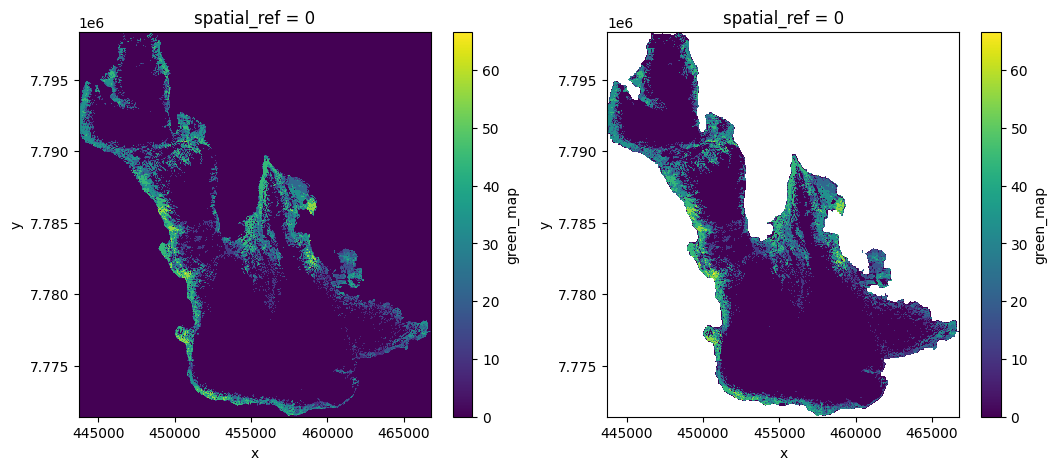

In [16]:
# d) visualise results
fig, axs = plt.subplots(1, 2, figsize=(12.5, 5))
th.tile_results["green_map"].plot(ax=axs[0])
th_ext.tile_results["green_map"].plot(ax=axs[1]);

Another useful custom verb is the change_dtype verb as defined below. Per default, semantique runs all calculations and result representations in float64. The required disk space to write the final results can be easily cut in half or less by converting the output to float32 or, if possible, even an integer dtype. Note that for the later, combinations of change_dtype with update_na are required to achieve a meaningful representation of NA values (since np.NaN is only defined for floating point dtypes).

In [17]:
from gsemantique.process.utils import change_dtype
??change_dtype

Signature:
change_dtype(
    obj,
    track_types=True,
    dtype='float32',
    na_value=None,
    **kwargs,
)
Docstring: <no docstring>
Source:   
def change_dtype(obj, track_types=True, dtype="float32", na_value=None, **kwargs):
    # self-contained imports
    import semantique as sq

    # convert dtype
    newobj = obj.copy(deep=True)
    newobj.values = newobj.astype(dtype)
    # track value types
    if track_types:
        newobj.sq.value_type = sq.processor.types.get_value_type(newobj)
    return newobj
File:      c:\users\felix\repositories\gsemantique\gsemantique\process\utils.py
Type:      function